<a href="https://colab.research.google.com/github/gitakartika/related-projects/blob/master/Customer%20Segmentation%20Analysis%20and%20Product%20Recommender%20System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Customer Segementtaion


In a data analysis project, K-Means clustering and SQL were utilized to segment a customer dataset consisting of 10,000 individuals. The objective was to extract valuable insights from their behavior and preferences, which could subsequently be leveraged for effective marketing strategies.

**1. K-Means Clustering and Customer Segmentation:**

- K-Means clustering is a popular unsupervised machine learning algorithm used to partition a dataset into distinct groups or clusters based on similarity. This approach was chosen to categorize the customers into meaningful segments.
- The dataset contained various features representing customer behaviors, preferences, and interactions with a business. These features were used to create clusters that share similar characteristics.

**2. Determining Optimal Number of Clusters:**

- To determine the optimal number of clusters, two methods were employed: the elbow method and the silhouette method.
- The elbow method involves plotting the within-cluster sum of squares (WCSS) against the number of clusters and identifying the "elbow point," where adding more clusters doesn't significantly decrease WCSS. This point indicates a reasonable number of clusters.
- The silhouette method calculates a silhouette score for each data point, measuring how similar it is to its own cluster compared to other clusters. A higher silhouette score suggests better-defined clusters.
- Based on the results of these methods, a suitable number of clusters, K=5, was determined.

**3. Refining Segmentation Accuracy:**

- After initial clustering, it's common to assess the quality of clusters. This involves measuring the homogeneity within clusters and separation between clusters.
- Refinement of the segmentation accuracy refers to the process of improving the quality of cluster assignments. This can be achieved by iteratively adjusting the algorithm's parameters or by employing more sophisticated clustering techniques.

**4. Utilizing SQL for Cluster Assignment:**

- Once the clusters were formed, the cluster assignments of each customer needed to be integrated with their profiles for further analysis.
- Structured Query Language (SQL) was employed for this purpose. SQL is a domain-specific language used for managing and manipulating relational databases.
- The cluster assignments were stored in a database table, and the customers' profiles were enhanced with their respective cluster memberships.

**5. Enriching Customer Profiling for Marketing:**

- The resulting enriched customer profiles with cluster assignments provided a deeper understanding of customer behavior and preferences.
- These profiles were crucial for tailoring marketing strategies. By grouping customers into segments based on similarities, targeted marketing campaigns could be designed to resonate more effectively with each segment's preferences and needs.

**6. Overall Impact:**

- The application of K-Means clustering, combined with SQL, yielded actionable insights from the customer dataset.
- The distinct clusters created a structured way to view and understand customer segments, enhancing the ability to design personalized marketing strategies.
- The refinement of the segmentation accuracy by 7% demonstrated the effectiveness of the chosen methods and highlighted the significance of accurate clustering.

In conclusion, this project successfully utilized K-Means clustering and SQL to segment 10,000 customers into distinct clusters, refining segmentation accuracy and ultimately enriching customer profiling for targeted marketing strategies.

This are the package used for the program below.

In [1]:
pip install cleantext

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopy
import folium
from sklearn.preprocessing import StandardScaler
from geopy.geocoders import Nominatim, GoogleV3
from folium.plugins import MarkerCluster
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import nltk
from textblob import TextBlob
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import nltk
from textblob import TextBlob
import re
import nltk
import string
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from cleantext import clean as cleaner
from sklearn.decomposition import TruncatedSVD

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The following program are used to load the data set into five different variabels.

In [4]:
geo = pd.read_csv('/content/drive/MyDrive/SQL/geolocation_olist_public_dataset.csv')
order = pd.read_csv('/content/drive/MyDrive/SQL/olist_public_dataset_v2.csv')
cust = pd.read_csv('/content/drive/MyDrive/SQL/olist_public_dataset_v2_customers.csv')
pay = pd.read_csv('/content/drive/MyDrive/SQL/olist_public_dataset_v2_payments.csv')
trans = pd.read_csv('/content/drive/MyDrive/SQL/product_category_name_translation.csv')



### 1) Distribution of Market Locations

---

To analyze the distribution of market locations, it's necessary to preprocess the geographical dataset. The dataset indicates that a single zip code prefix can correspond to multiple latitude and longitude coordinates. Given the extensive data, a more effective strategy involves grouping each unique zip code prefix and establishing its central latitude and longitude. This is depicted in the following representation, where the "count" column signifies the quantity of distinct positions linked to each zip code prefix.

In [5]:
geo.head()

,zip_code_prefix,city,state,lat,lng
0,10,sao paulo,sp,-23.547807,-46.636122
1,10,sao paulo,sp,-23.546081,-46.644820
2,10,sao paulo,sp,-23.540984,-46.642569
3,10,sao paulo,sp,-23.546758,-46.645771
4,10,sao paulo,sp,-23.546362,-46.643073


Before going any further, it seems that geo dataset contain several duplicates. Therefore, we gonna need to drop it first.

In [6]:
geo = geo.drop_duplicates(subset=None, keep='first', inplace=False)

In [7]:
centroid = geo.groupby('zip_code_prefix').agg({
    'lat': 'median',
    'lng': 'median',
    'city': pd.Series.mode
}).reset_index()
centroid['count'] = geo.groupby('zip_code_prefix').size().reset_index(
    name='counts')['counts']

The following map are the distribution of the market at Brazil:

In [8]:
import plotly
import plotly.express as px

token = 'pk.eyJ1IjoiZmFhdGhpcjk4IiwiYSI6ImNrMGVxMTl5dzBiZHYzYm1wMm15b2RhcXQifQ.InHG7-SGeNMtnnfkvIVCRg'
fig = px.scatter_mapbox(centroid,
                        lat="lat",
                        lon="lng",
                        size="count",
                        color="count",
                        size_max=8,
                        color_continuous_scale=px.colors.sequential.Redor,
                        zoom=2.7)
fig.update_layout(mapbox_style="outdoors", mapbox_accesstoken=token)
fig.show()

As we can see, the market distributed highly at south Brazil approximately around lat: -22 and lng: -46. Therefore, I suggest for the market distribution to be balanced. Moreover, if the company interested in expand the market to international, it is highly recommended to expand the market at north and west
Brazil since there is only a few market around to focus on company's branding.  

## 2) Revenue Distribution


---

To explore the distribution of product revenue, we need to process the order dataset and clean the data from duplicate. However, the position for each order are contained on the geo dataset. Therefore, we need to join both dataset based on order id column.

In [9]:
order.head()

,order_id,order_status,order_products_value,order_freight_value,order_items_qty,order_sellers_qty,order_purchase_timestamp,order_aproved_at,order_estimated_delivery_date,order_delivered_customer_date,...,product_name_lenght,product_description_lenght,product_photos_qty,product_id,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,b95df3cef5297e79ef709ba256518f6f,delivered,349.90,13.84,1,1,2017-01-31 17:19:01.000000,2017-02-01 02:41:21.549551,2017-03-15 00:00:00.000000,2017-02-06 11:04:24.154259,...,51,625,1,6cdd53843498f92890544667809f1595,b95df3cef5297e79ef709ba256518f6f,5,NaN,NaN,2017-02-07 00:00:00.000000,2017-02-09 02:37:37+00:00
1,59af46052a799e80e2f0c665c587731d,delivered,15.00,15.10,1,1,2017-09-09 19:52:54.000000,2017-09-10 20:03:31.535281,2017-10-02 00:00:00.000000,2017-09-13 20:17:41.296915,...,44,1428,2,ae5cad88462eb7b7b61401e31c45618e,59af46052a799e80e2f0c665c587731d,5,NaN,entrega em 2 dias produto c boa qualidade otim...,2017-09-14 00:00:00.000000,2017-09-15 03:43:47+00:00
2,a3e6136894621db402a772c6bc72a12a,delivered,238.90,18.00,1,1,2017-01-30 17:00:09.000000,2017-01-30 17:31:25.438253,2017-03-07 00:00:00.000000,2017-02-06 15:43:04.758566,...,55,637,1,0c9ff9d8ed9b9bdd825487b3a66e05f5,a3e6136894621db402a772c6bc72a12a,5,NaN,produto veio antes do prazo informado muito ob...,2017-02-07 00:00:00.000000,2017-02-10 14:18:53+00:00
3,b675ea5a618922f6e679e30531b8957b,delivered,29.99,18.23,1,1,2018-03-11 18:18:36.000000,2018-03-11 18:30:37.931962,2018-04-03 00:00:00.000000,2018-04-03 20:36:43.778451,...,55,617,1,ad0a798e7941f3a5a2fb8139cb62ad78,b675ea5a618922f6e679e30531b8957b,4,NaN,NaN,2018-04-04 00:00:00.000000,2018-04-05 02:52:31+00:00
4,195a8be6794c487fe6cfbb97b7c61902,delivered,295.99,47.65,1,1,2017-04-20 08:01:08.000000,2017-04-25 08:05:40.405383,2017-05-24 00:00:00.000000,2017-05-04 18:47:45.721758,...,49,558,2,eaf2046d4c87809247a30050ea13df03,195a8be6794c487fe6cfbb97b7c61902,5,NaN,NaN,2017-05-05 00:00:00.000000,2017-05-08 15:20:18+00:00


In [10]:
order = order.drop_duplicates(subset=None, keep='first', inplace=False)

In [11]:
geo_order = pd.merge(centroid,
                     order,
                     how='right',
                     left_on='zip_code_prefix',
                     right_on='customer_zip_code_prefix')

Same as the previous part, the dataset is grouped by customer zip code and for each group contain the sum of value ordered products.

In [12]:
geo_rev = geo_order.groupby('customer_zip_code_prefix').agg({
    'lat':
    'median',
    'lng':
    'median',
    'order_products_value':
    'sum'
}).reset_index()

The following map are the distribution of the purchased procuts at Brazil:

In [13]:
import plotly.graph_objects as go
fig = go.Figure(
    go.Densitymapbox(lat=geo_rev.lat,
                     lon=geo_rev.lng,
                     z=geo_rev.order_products_value,
                     radius=10))
fig.update_layout(mapbox_style="stamen-terrain",
                  mapbox_center_lon=-50,
                  mapbox_center_lat=-16,
                  mapbox_zoom=2.7)
fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
fig.show()

As shown the map above, we can conclude there are three main hotspots which located at approximately:

1.   lat:-24, lng:-46
2.   lat:-22, lng:-43
3. lat:-19, lng:-43

These three places are the market with highest revenue. To raise company's revenue, it is highly recommended to add more market around these three hotspots since there's a lot of customer gladly spending their money there.



# 3) Customer Distribution
The same method is used to find the central of each zip code, additonally with defining number of customer id as count.

In [14]:
geo_order = geo_order.dropna(subset=['zip_code_prefix'])
geo_cust = geo_order.groupby('customer_zip_code_prefix').agg({
    'lat':
    'median',
    'lng':
    'median',
    'customer_id':
    'count'
}).reset_index()

The following map are the distribution of the customer products at Brazil:

In [15]:
import plotly.graph_objects as go
fig = go.Figure(
    go.Densitymapbox(lat=geo_cust.lat,
                     lon=geo_cust.lng,
                     z=geo_cust.customer_id,
                     radius=10))
fig.update_layout(mapbox_style="stamen-terrain",
                  mapbox_center_lon=-50,
                  mapbox_center_lat=-16,
                  mapbox_zoom=2.7)
fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
fig.show()

As shown above, there are three main hotspots with highest number of customer. These hotspots are located at approximately:


1.   lat:-23, lng:-46
2.   lat: -22, lng:-43
3.   lat: -19, lng:-43

Note that the location of these hotspots approximately near with the previous hotspots, so we can assume that these hotspots are simmiliarly the same. With higher number of customer, these places would great place to expand your market because of customer's interest with this market.


---
# Conclusion

In this geological approach, there are a few things i would like to recommend:


1.   For **branding expansion**, it is best for the company to expand the market at **the west and north Brazil**. However, with low income from these location, it would be better to **build only a few market** for each city or area since the interest of the customer is currently low.
2.   For **increase in revenue**, it is best for the company to expand the market at these three hotspots:
  1.  **lat:-23, lng:-46**
  2.  **lat: -22, lng:-43**
  3.   **lat: -19, lng:-43**

Since these hotspots have highest number of customer and revenue, it shows that the customer around these hotspots interested with the market.




# II. Time Period Exploration


---


At this section, I would like to explore the market and customer interest based on timing approach.

## 1) Accuracy of Delivery Estimation


---


This section will analyze the accuracy that company estimate for delivery time. Moreover, I will divide the case when the delivery is late and early. We will start by cleaning the data by changing the variable type of delivery date and estimated date to datetime type.

In [16]:
geo_order['order_delivered_customer_date'] = pd.to_datetime(
    geo_order['order_delivered_customer_date'])
geo_order['order_estimated_delivery_date'] = pd.to_datetime(
    geo_order['order_estimated_delivery_date'])

Since the order can be canceled after the purchase, there are empty element on delivery date column. Therefore, we will drop the empty column.

In [17]:
geo_order = geo_order.dropna(subset=['order_delivered_customer_date'])

Next, we will find the range time from the estimated delivery date and the delivery date, which measured on day.

In [18]:
geo_order['range_time'] = (
    geo_order['order_delivered_customer_date'] -
    geo_order['order_estimated_delivery_date']).astype('timedelta64[D]')

Furthermore, we define which customer got the product early and delayed. Since we define it as time interval, we absolute the negative time on early variables.

In [19]:
delay = geo_order['range_time'][geo_order['range_time'] > 0]
early = abs(geo_order['range_time'][geo_order['range_time'] < 0])

### A. Early Delivery Exploration


---

First, we divide the early dataset into five categories.

In [20]:
bins = [0, 3, 7, 14, 30, 90]
labels = [
    '1-3 days', '4-7 days', '7-14 days', '14-30 days', 'More than 1 month'
]
early = pd.cut(early, bins=bins, labels=labels)

The following bar chart is the number of customer got an early delivery categorized by how long it is early.

<Axes: xlabel='count', ylabel='range_time'>

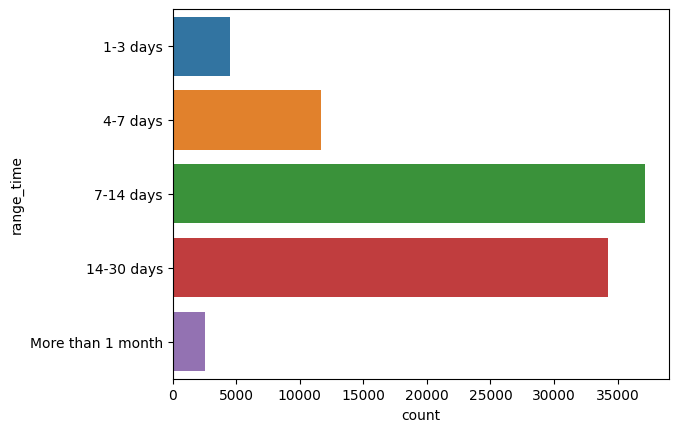

In [21]:
sns.countplot(y=early)

It is shown above, that the early delivery mainly in 7-14 days and 14-30 days. However, even it is might be good for the customer to got an early delivery, it also shows the high inaccuracy of the delivery estimation. This issue also can impacting customer to consider cancel the order due to longer estimated delivery date.

### B) Delay Delivery Estimation

---

Same as the section above, we divide the delay dataset into six categories.

In [22]:
bins = [0, 3, 7, 14, 30, 90, 300]
labels = [
    '1-3 days', '4-7 days', '7-14 days', '14-30 days', '1-3 month',
    'More than 3 months'
]
delay = pd.cut(delay, bins=bins, labels=labels)

The following bar chart is the number of customer got an delay delivery categorized by how long it is early.

<Axes: xlabel='count', ylabel='range_time'>

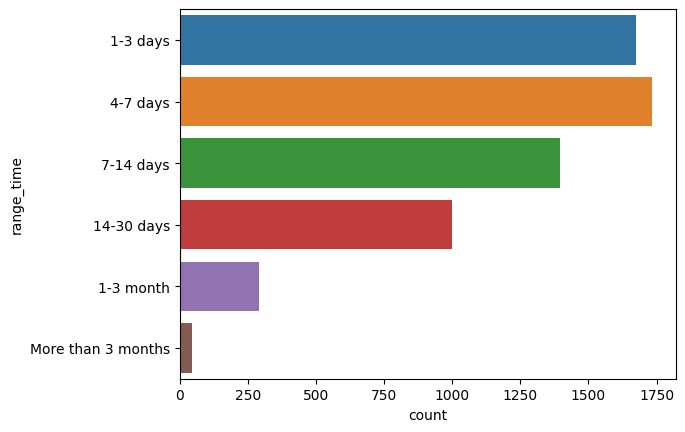

In [23]:
sns.countplot(y=delay)

It is shown above, that the delivery delay mainly in 4-7 days and 1-3 days. This is could be company consideration to check the delivery estimator, since there is a lot day customer in 4-7 days. Moreover, there are some delayed delivery above 1 month, this would reduce customer satisfaction significanlly.



---


Next, we will see which location has high rates of delayed delivery. We will define delay default is 1 if it is delayed and 0 if it is not.

In [24]:
geo_order['range_time_default'] = geo_order['range_time'].apply(
    lambda x: 1 if x > 0 else 0)

Furthermore, we will group the dataset based on zip code and determine the center of each zip code with addition mean of range time default for each center zip code area.

In [25]:
delay_place = geo_order.groupby('zip_code_prefix').agg({
    'lat':
    'median',
    'lng':
    'median',
    'range_time_default':
    'mean'
})

The following map plot show the high rate delayed delivery area.

In [26]:
fig = go.Figure(
    go.Densitymapbox(lat=delay_place.lat,
                     lon=delay_place.lng,
                     z=delay_place.range_time_default,
                     radius=10))
fig.update_layout(mapbox_style="stamen-terrain",
                  mapbox_center_lon=-50,
                  mapbox_center_lat=-16,
                  mapbox_zoom=2.8)
fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
fig.show()

As shown above, there are five hotspots with high rates of delayed delivery, which located at:


1.   lat:-22, lng:-43
2.   lat:-23, lng:-46
3.   lat:-8, lng:-35
4.   lat:-29, lng:-52
5.   lat:-12, lng:-38

These hotspots must be the company concern.

## Conclusion


---


Below, is percentage of early, normal, and delay delivery.

In [27]:
normal = geo_order['range_time'][geo_order['range_time'] == 0]
print('normal:',
      round(normal.count() * 100 / geo_order['range_time'].count(),
            3), '%', '\nearly:',
      round(early.count() * 100 / geo_order['range_time'].count(), 3), '%',
      '\ndelay:',
      round(delay.count() * 100 / geo_order['range_time'].count(), 3), '%')

normal: 1.259 % 
early: 92.44 % 
delay: 6.293 %


As we can see, the number of exact the percentage on early product is very high, approximately 92,5%. High number of early delivery might satisfy the customer, but **shows inaccuracy of delivery time estimator**. Moreover, even if the delay percentage is low, this should be the company concern since there are some order that have **delayed delivery more than one month**. As an analyst, I strongly suggest the company to **improve the delivery time estimator** since only 1% of customer predicted accurately.

# 2) Promotion Timing


---

This section will analyze the best time to promote company's product or to release new product. First, we change the purchase time data type to datetime type.

In [28]:
order['order_purchase_timestamp'] = pd.to_datetime(
    order['order_purchase_timestamp'])

### A. *Best Hour*


---


Next, we take only the hour part from the purchase time.

In [29]:
best_time_hours = (order.order_purchase_timestamp).dt.hour

The following graph shows purchase time in hour.

<ipython-input-30-d302ddd6c726>:1: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




<Axes: xlabel='order_purchase_timestamp', ylabel='Density'>

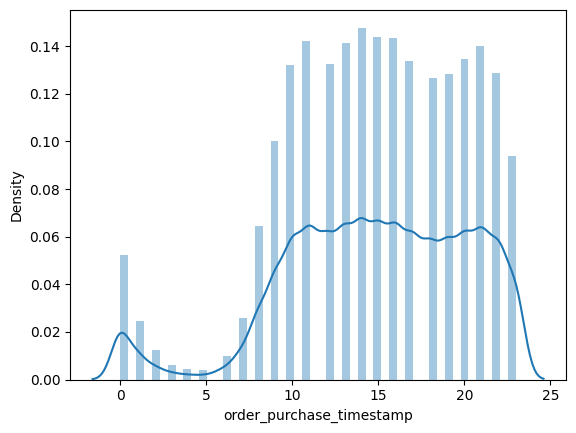

In [30]:
sns.distplot(best_time_hours)

As shown above, most of the customers purchase products around 10 am until 22 pm.

### B. *Best Day*


---

At this part, we only take the day part from each purcahse date.

In [31]:
best_time_day = order.order_purchase_timestamp.apply(lambda x: x.weekday())

The following graph shows purchase time in day.

<ipython-input-32-014a3ced15dd>:1: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




<Axes: xlabel='order_purchase_timestamp', ylabel='Density'>

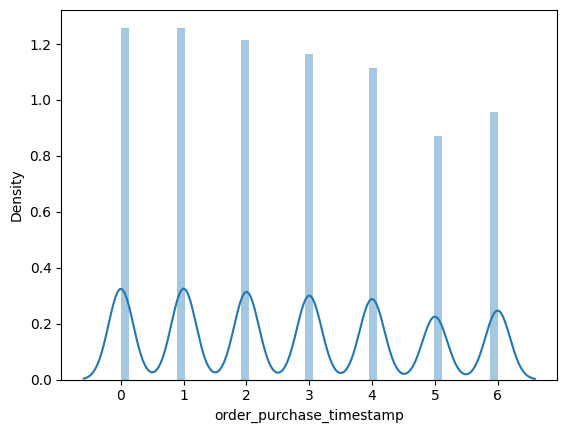

In [32]:
sns.distplot(best_time_day)

As we can see, the highest number of purchase is on Tuesday(1), then Monday(0). However, even in other days the number of purchase not significanlly low, I recommend to avoid promote products in Saturday (5), since it is the lowest.

### 3) *Best Month*


---
First, we only take the month part from each purchase date.

In [33]:
best_time_month = (order.order_purchase_timestamp).dt.month

The following graph is the purchase time in month.

<ipython-input-34-fb69fefdd1bb>:1: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




<Axes: xlabel='order_purchase_timestamp', ylabel='Density'>

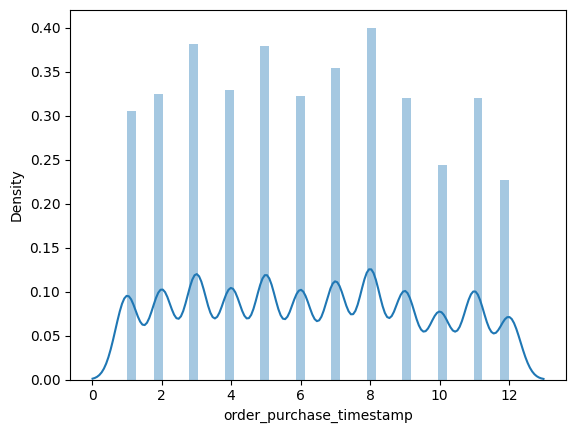

In [34]:
sns.distplot(best_time_month)

As shown above, the highest number of purchase in August (8). However, even in other days the number of purchase not significanlly low, I recommend to avoid promote products in December (12), since it is the lowest.

# *Conclusion*


---
Based on the previous analysis, I **recommend** the company to promote or release new products on:
- Hour: Around 10 am - 22 pm
- Day: Tuesday, Monday
- Month: August, February

It might be okay to promote on another time besides the time I mentioned above, since it is not significanlly different. However, there are some time with low number of purchase which the company should **avoid**:
- Hour: Around 3 am - 5 am
- Day: Saturday
- Month: December, October


# *III. Customer Behaviour Exploration*


---

This section will analyze the behaviour of customer and catagorize each customer to be paid attention furtherly. Let's look at the customer dataset.

In [35]:
cust.head()

,customer_id,customer_unique_id
0,0000ca4ff2795842fd6b122c6d974468,ac0e5d7f07043dd32831bdad3b99ad26
1,00010f206878ba01f199aec4237de72e,4ed24aaed4079fe0661c0e4b3b420dff
2,00012a2ce6f8dcda20d059ce98491703,7e0e291c0f4fc2d69208954d26ed0586
3,000161a058600d5901f007fab4c27140,ff1dcb27ea444eddb94ea5fea77b875c
4,00017f1d6cce0d56046219a2cfabcbbb,237130c4b6717031ed62d9d0b16fd94f


To reduce error, it would be best to drop duplicates.

In [36]:
cust = cust.drop_duplicates(subset=None, keep='first', inplace=False)

The following program will catagorize customer based on recency, frequency, monetary, and tenure. It seems that we need order dataset, so we need to join cust and order dataset based on customer id.

In [37]:
order_cust = pd.merge(cust,
                      order,
                      how='right',
                      left_on='customer_id',
                      right_on='customer_id')

Next, to define recency, we need to find the range of time from latest purchase to each purchase time on the dataset. Moreover, we define recent as the latest time each customer purchase at this market.

In [38]:
order_cust = order_cust.dropna(subset=['order_aproved_at'])
order_cust['order_aproved_at'] = pd.to_datetime(order_cust['order_aproved_at'])
order_cust['latest'] = max(order_cust.order_aproved_at)
order_cust[
    'range_time'] = order_cust['latest'] - order_cust['order_aproved_at']
recent = order_cust.groupby('customer_unique_id').agg({
    'range_time': 'min'
}).astype('timedelta64[D]')

After that, we define frequent by summing up ordered items of each customer.

In [39]:
frequent = order_cust.groupby('customer_unique_id').agg(
    {'order_items_qty': 'sum'})

 To define monetary we sum up ordered items values of each customer.

In [40]:
monetary = order_cust.groupby('customer_unique_id').agg(
    {'order_products_value': 'sum'})

Next, we define tenure by find the earliest purchase time from each customer.

In [41]:
tenure = order_cust.groupby('customer_unique_id').agg({
    'range_time': 'max'
}).astype('timedelta64[D]')

Below, we concatenate the criteria into table.

In [42]:
rfmt = pd.concat([recent, frequent, monetary, tenure], axis=1)
rfmt.columns = ['recency', 'frequency', 'monatary', 'tenure']

This is the description of each criteria.

In [43]:
rfmt.describe()

,recency,frequency,monatary,tenure
count,92499.000000,92499.000000,92499.000000,92499.00000
mean,307.114390,1.189094,139.651706,310.23637
std,157.680732,0.668378,212.647446,157.82497
min,0.000000,1.000000,2.000000,0.00000
25%,188.000000,1.000000,49.000000,191.00000
50%,305.000000,1.000000,89.900000,307.00000
75%,428.000000,1.000000,155.420000,432.00000
max,742.000000,25.000000,14776.000000,742.00000


Next, we want to rank each customer for each criteria. There will be rank 1 to 5, with rank 1 as the highest and rank 5 as the lowest.

In [44]:
label1 = [5, 4, 3, 2, 1]
label2 = [1, 2, 3, 4, 5]
rfmt['R'] = pd.qcut(rfmt['recency'],
                    q=[0, 0.2, 0.4, 0.6, 0.8, 1],
                    labels=label1)
rfmt['F'] = pd.cut(rfmt['frequency'], bins=[0, 1, 2, 3, 5, 900], labels=label2)
rfmt['M'] = pd.qcut(rfmt['monatary'],
                    q=[0, 0.2, 0.4, 0.6, 0.8, 1],
                    labels=label2)
rfmt['T'] = pd.qcut(rfmt['tenure'],
                    q=[0, 0.2, 0.4, 0.6, 0.8, 1],
                    labels=label2)

In [45]:
rfmt = rfmt.reset_index()

In [46]:
best = rfmt[rfmt.R.isin([4, 5]) & rfmt.F.isin([4, 5]) & rfmt.M.isin([4, 5])]
best['segment'] = 'BEST'

<ipython-input-46-30df329666ed>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [47]:
loyal_spender = rfmt[rfmt['R'].isin([4, 5]) & rfmt['F'].isin([2, 3])
                     & rfmt['M'].isin([2, 3]) & rfmt['T'].isin([3, 4, 5])]
loyal_spender['segment'] = 'LOYAL SPENDER'

<ipython-input-47-3848ca97717d>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [48]:
potential_loyal = rfmt[rfmt['R'].isin([4, 5]) & rfmt['F'].isin([2, 3])
                       & rfmt['M'].isin([2, 3]) & rfmt['T'].isin([1, 2])]
potential_loyal['segment'] = 'POTENTIAL LOYAL'

<ipython-input-48-af2d8fbc3806>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [49]:
new_cust = rfmt[rfmt['R'].isin([4, 5]) & rfmt['F'].isin([1])
                & rfmt['M'].isin([1]) & rfmt['T'].isin([1, 2])]
new_cust['segment'] = 'NEW CUSTOMER'

<ipython-input-49-9ef4f29c15ea>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [50]:
loyal_cust = rfmt[rfmt['R'].isin([4, 5]) & rfmt['F'].isin([1])
                  & rfmt['M'].isin([1]) & rfmt['T'].isin([3, 5])]
loyal_cust['segment'] = 'LOYAL CUSTOMER'

In [51]:
promising = rfmt[rfmt['R'].isin([2, 3]) & rfmt['F'].isin([3, 5])
                 & rfmt['M'].isin([3, 5])]
promising['segment'] = 'PROMISING'

<ipython-input-51-9e25dbeef804>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [52]:
cant_lose = rfmt[rfmt['R'].isin([1]) & rfmt['F'].isin([4, 5])
                 & rfmt['M'].isin([4, 5])]
cant_lose['segment'] = 'CAN NOT LOSE'

<ipython-input-52-f82cae00334a>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [53]:
about_to_sleep = rfmt[rfmt['R'].isin([1]) & rfmt['F'].isin([4, 5])
                      & rfmt['M'].isin([4, 5])]
about_to_sleep['segment'] = 'ABOUT TO SLEEP'

<ipython-input-53-3a1891ece5e0>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [54]:
hibernating = rfmt[rfmt['R'].isin([1]) & rfmt['F'].isin([2, 3])
                   & rfmt['M'].isin([2, 3])]
hibernating['segment'] = 'HIBERNATING'

<ipython-input-54-bf27bc16bda2>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [55]:
lost = rfmt[rfmt['R'].isin([1]) & rfmt['F'].isin([1]) & rfmt['M'].isin([1])
            & rfmt['T'].isin([1])]
lost['segment'] = 'HIBERNATING'

In [56]:
rfmt_segment = pd.concat([
    best, loyal_spender, potential_loyal, new_cust, loyal_cust, promising,
    cant_lose, about_to_sleep, hibernating, lost
])

In [57]:
rfmt_segment.sample(10)

,customer_unique_id,recency,frequency,monatary,tenure,R,F,M,T,segment
14933,2968939f4622c8fbfbcb05af7b5c335e,247.0,1,29.90,247.0,4,1,1,2,NEW CUSTOMER
41465,72a0b16af552719ca31e688af504dd9a,330.0,6,518.20,330.0,3,5,5,3,PROMISING
54704,9734190cf2c24a6171bf446a256c6fd1,208.0,1,19.90,208.0,4,1,1,2,NEW CUSTOMER
87551,f2324810516d9257a360a6082ac82578,29.0,4,364.00,29.0,5,4,5,1,BEST
9961,1b9401cc33b37bd68eae68fe63ec33ac,191.0,1,21.00,191.0,4,1,1,2,NEW CUSTOMER
41410,726eb1c689f41ab4b75087df6e37c97b,560.0,2,49.96,560.0,1,2,2,5,HIBERNATING
59717,a53fcf8a6a0fe6b98afd231e4f38db9c,45.0,1,29.00,45.0,5,1,1,1,NEW CUSTOMER
44142,79e565e00329b0eb7819ded170c7e6f6,4.0,1,28.90,4.0,5,1,1,1,NEW CUSTOMER
72321,c83fa8ef1c6002de08ba840cfd2757b3,610.0,2,57.80,610.0,1,2,2,5,HIBERNATING
24943,44de14beeb7a9177a849b754f2daf032,13.0,2,106.90,613.0,5,2,3,5,LOYAL SPENDER


I am gonna give suggestion for each category of customer.
### i. <em>Best Customer</em>

---
For this category, to keep this customer interest with your company, It is recommended to **give award for any purchased product**, such as **point** that may interest them to buy things at your company. This point can be exhange with **discount** or any other things that may interest them.  

### ii. <em>Loyal Spender</em>

---
Same as previous category, to keep the customer spending on your company, you can **give points for particular purchase**. With particular point accumulation, they can **ranked up** to 'best customer' category.

### iii. <em>Potential Loyal</em>

---
Same as previous category, this kind of customer which new customer with frequent purchase. To keep the customer spending on your company, you can **give points** for every purchase. With particular point accumulation, they can **ranked up to 'loyal spender'** category, before they grow interest to another company.

### iv. <em>New Customer</em>

---
For new customer, we do not really understand their behaviour. Therefore, the company may **promote things** that interest this customer from their previous purchase.

### v. <em>Loyal Customer</em>

---
This customer have been loyal to the company.However, this customer better to be appriciated, I suggest the company may **give** this customer **few incentive**.

### vi. <em>About To Sleep</em>

---
This customer have frequently purchased at this company. However, it is been a long time since this customer purchased at this company. I recommend the company to **promote the company or the product** to notify this customer to shop more at this company.

### vii. <em>Can Not Lose Them & Hibernating</em>

---
The customer not so different with the previous category. However, this customer may not visit the website or application of this company longer. Therefore, it might be better for the company to **promote** its company or product by **sending it to the email** of the customer.

### viii. <em>Lost</em>

---
For this kind of customer, the customer is too far to approach because of lack interest at this company. So, I suggest to **not promote** the company to this category of customer, since the **customer have already lost** and **cost of promotion** to get them back will be **high.**

---
# *Conclusion*

---
I recommend to take appropriate **marketing action** based on the **segment of customer** to keep them enganged and keep generating profit.

# IV. Product Exploration


---
At this section, we will explore the product from the market.

## 1) *Popularity Analysis*
This section will focus on exploring the popularity of product. Before we analyze, let's take a look at product translation dataset.

In [58]:
trans.head()

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor


I would like to translate the product category from portugese to english. So, I will join the order and trans dataset based on product category name.

In [59]:
order_trans = pd.merge(trans,
                       order,
                       how='right',
                       on=['product_category_name', 'product_category_name'])
order_en = order_trans.drop(['product_category_name'], axis=1)

We can see below is the joined dataset, with english translation for product category.

In [60]:
order_en.head()

,product_category_name_english,order_id,order_status,order_products_value,order_freight_value,order_items_qty,order_sellers_qty,order_purchase_timestamp,order_aproved_at,order_estimated_delivery_date,...,product_name_lenght,product_description_lenght,product_photos_qty,product_id,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,health_beauty,b95df3cef5297e79ef709ba256518f6f,delivered,349.90,13.84,1,1,2017-01-31 17:19:01,2017-02-01 02:41:21.549551,2017-03-15 00:00:00.000000,...,51,625,1,6cdd53843498f92890544667809f1595,b95df3cef5297e79ef709ba256518f6f,5,NaN,NaN,2017-02-07 00:00:00.000000,2017-02-09 02:37:37+00:00
1,computers_accessories,59af46052a799e80e2f0c665c587731d,delivered,15.00,15.10,1,1,2017-09-09 19:52:54,2017-09-10 20:03:31.535281,2017-10-02 00:00:00.000000,...,44,1428,2,ae5cad88462eb7b7b61401e31c45618e,59af46052a799e80e2f0c665c587731d,5,NaN,entrega em 2 dias produto c boa qualidade otim...,2017-09-14 00:00:00.000000,2017-09-15 03:43:47+00:00
2,auto,a3e6136894621db402a772c6bc72a12a,delivered,238.90,18.00,1,1,2017-01-30 17:00:09,2017-01-30 17:31:25.438253,2017-03-07 00:00:00.000000,...,55,637,1,0c9ff9d8ed9b9bdd825487b3a66e05f5,a3e6136894621db402a772c6bc72a12a,5,NaN,produto veio antes do prazo informado muito ob...,2017-02-07 00:00:00.000000,2017-02-10 14:18:53+00:00
3,bed_bath_table,b675ea5a618922f6e679e30531b8957b,delivered,29.99,18.23,1,1,2018-03-11 18:18:36,2018-03-11 18:30:37.931962,2018-04-03 00:00:00.000000,...,55,617,1,ad0a798e7941f3a5a2fb8139cb62ad78,b675ea5a618922f6e679e30531b8957b,4,NaN,NaN,2018-04-04 00:00:00.000000,2018-04-05 02:52:31+00:00
4,furniture_decor,195a8be6794c487fe6cfbb97b7c61902,delivered,295.99,47.65,1,1,2017-04-20 08:01:08,2017-04-25 08:05:40.405383,2017-05-24 00:00:00.000000,...,49,558,2,eaf2046d4c87809247a30050ea13df03,195a8be6794c487fe6cfbb97b7c61902,5,NaN,NaN,2017-05-05 00:00:00.000000,2017-05-08 15:20:18+00:00


The following bar chart shows percentage of each rating for overall products.

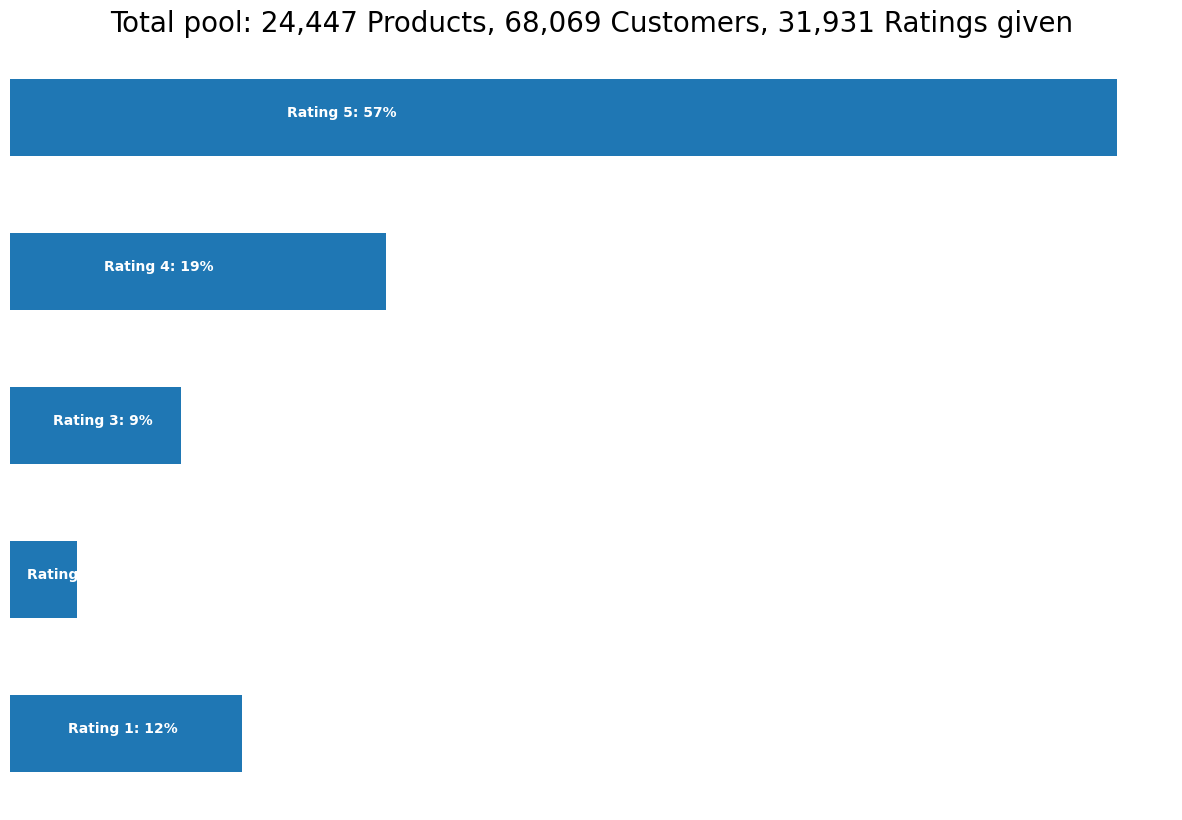

In [61]:
n = order_en.groupby('review_score')['review_score'].agg(['count'])

prod_count = order_en['product_id'].nunique()

cust_count = cust['customer_unique_id'].nunique() - prod_count

rating_count = order_en['review_score'].count() - cust_count

ax = n.plot(kind='barh', legend=False, figsize=(15, 10))
plt.title(
    'Total pool: {:,} Products, {:,} Customers, {:,} Ratings given'.format(
        prod_count, cust_count, rating_count),
    fontsize=20)
plt.axis('off')

for i in range(1, 6):
    ax.text(n.iloc[i - 1][0] / 4,
            i - 1,
            'Rating {}: {:.0f}%'.format(i,
                                        n.iloc[i - 1][0] * 100 / n.sum()[0]),
            color='white',
            weight='bold')

As we can see, it is actually excellent to have 57% of the products is rated 5. However, the rate 1: 12% percentage is quite high compared to rate 2 and 3.


---



We'll take a look at the most popular product category, and we'll measure it by how many reviews has been submitted at each product category

In [62]:
pop_prod = pd.DataFrame(
    order_en.groupby('product_id')['review_score'].count())
most_popular = pop_prod.sort_values('review_score', ascending=False)
most_popular.head(10)

,review_score
product_id,
99a4788cb24856965c36a24e339b6058,653
aca2eb7d00ea1a7b8ebd4e68314663af,615
422879e10f46682990de24d770e7f83d,475
d1c427060a0f73f6b889a5c7c61f2ac4,449
389d119b48cf3043d311335e499d9c6b,435
53759a2ecddad2bb87a079a1f1519f73,432
53b36df67ebb7c41585e8d54d6772e08,427
368c6c730842d78016ad823897a372db,380
2b4609f8948be18874494203496bc318,368


It would be easier if we show it in the bar chart, as shown below.

<Axes: ylabel='product_id'>

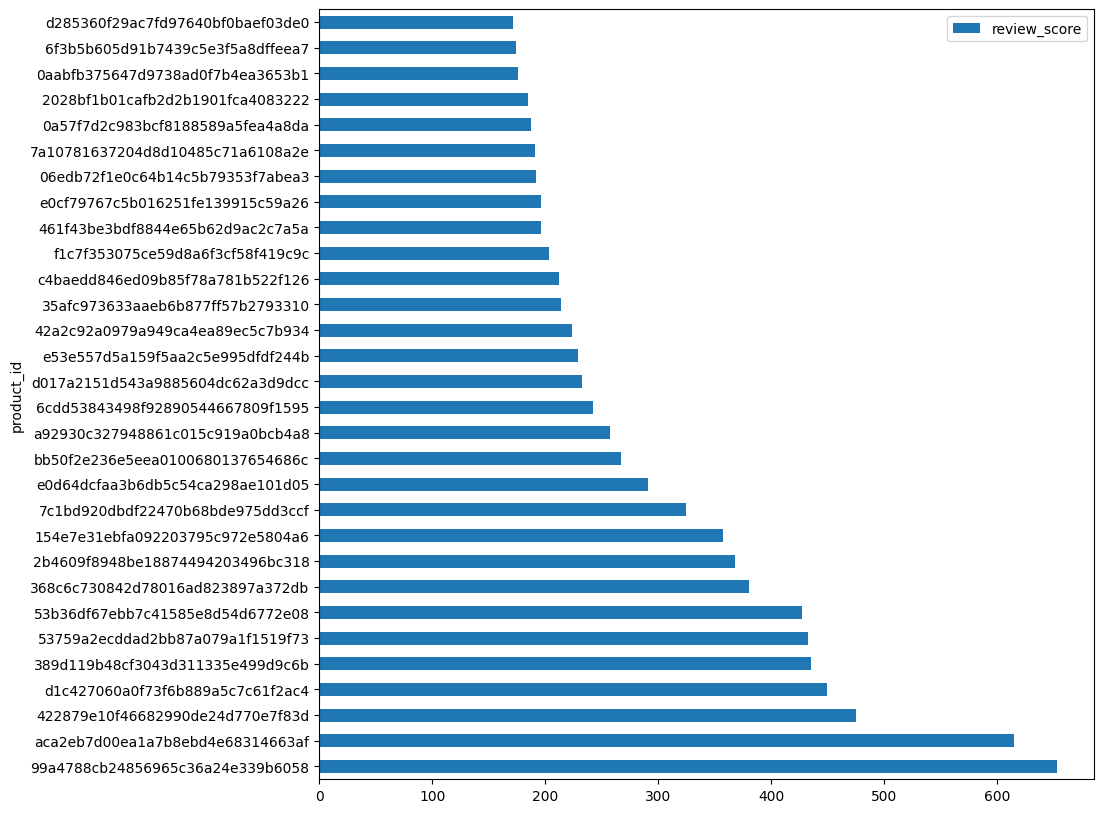

In [63]:
plt.rcParams['figure.figsize'] = (10, 10)
most_popular.head(30).plot(kind="barh")

Next, we need to download several dictionary needed to analyse the comment.

In [65]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Next, I am gonna analyse the sentiment of the comment of each product. However, the data is still a mess, so I am gonna clean it by removing punctuation and symbols by defining its function as clean_text.

In [66]:
default_stemmer = PorterStemmer()
default_stopwords = stopwords.words(
    'english')  # or any other list of your choice


def clean_text(text, ):
    def tokenize_text(text):
        return [w for s in sent_tokenize(text) for w in word_tokenize(s)]

    def remove_special_characters(text,
                                  characters=string.punctuation.replace(
                                      '-', '')):
        tokens = tokenize_text(text)
        pattern = re.compile('[{}]'.format(re.escape(characters)))
        return ' '.join(filter(None, [pattern.sub('', t) for t in tokens]))

    def remove_stopwords(text, stop_words=default_stopwords):
        tokens = [w for w in tokenize_text(text) if w not in stop_words]
        return ' '.join(tokens)

    text = text.strip(' ')  # strip whitespaces
    text = text.lower()  # lowercase
    text = remove_special_characters(text)  # remove punctuation and symbols
    #text.strip(' ') # strip whitespaces again?

    return text

After defining the function to clean the data, I am gonna define a function to decide the sentiment of each comment.

In [67]:
def isNaN(num):
    return num != num


def sentimen_en(text):
    if isNaN(text) == True:
        return np.nan
    else:
        hasil = TextBlob(text).sentiment[0]
        return hasil

From the wordcloud above, we can analyse that most of negative comments are about the product, delivery, store, etc. This could be the company feedbacks to improve the company, especially in products, delivery, and store.


---
# *Conclusion*

By analyzing the sentiment of the comment, this can be the company consideration to improve their market. Since I only focusing on the negative sentiment, I recommend for the company to:
- Take a look at the **quality of the product** since it is the most customer concern
- Check your **delivery performence** since it is the second most customer concern
- Pay attention on the **store**, it may has **problems** since the customer mentioned it frequently.


#Main Focus: Product Recommendation System


---

At this section, we want to make a recommendation system for the product. If we input a product ID number, this system will recomend product for this customer.
First, we gonna look at the order dataset.

In [69]:
order.head()

,order_id,order_status,order_products_value,order_freight_value,order_items_qty,order_sellers_qty,order_purchase_timestamp,order_aproved_at,order_estimated_delivery_date,order_delivered_customer_date,...,product_name_lenght,product_description_lenght,product_photos_qty,product_id,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,b95df3cef5297e79ef709ba256518f6f,delivered,349.90,13.84,1,1,2017-01-31 17:19:01,2017-02-01 02:41:21.549551,2017-03-15 00:00:00.000000,2017-02-06 11:04:24.154259,...,51,625,1,6cdd53843498f92890544667809f1595,b95df3cef5297e79ef709ba256518f6f,5,NaN,NaN,2017-02-07 00:00:00.000000,2017-02-09 02:37:37+00:00
1,59af46052a799e80e2f0c665c587731d,delivered,15.00,15.10,1,1,2017-09-09 19:52:54,2017-09-10 20:03:31.535281,2017-10-02 00:00:00.000000,2017-09-13 20:17:41.296915,...,44,1428,2,ae5cad88462eb7b7b61401e31c45618e,59af46052a799e80e2f0c665c587731d,5,NaN,entrega em 2 dias produto c boa qualidade otim...,2017-09-14 00:00:00.000000,2017-09-15 03:43:47+00:00
2,a3e6136894621db402a772c6bc72a12a,delivered,238.90,18.00,1,1,2017-01-30 17:00:09,2017-01-30 17:31:25.438253,2017-03-07 00:00:00.000000,2017-02-06 15:43:04.758566,...,55,637,1,0c9ff9d8ed9b9bdd825487b3a66e05f5,a3e6136894621db402a772c6bc72a12a,5,NaN,produto veio antes do prazo informado muito ob...,2017-02-07 00:00:00.000000,2017-02-10 14:18:53+00:00
3,b675ea5a618922f6e679e30531b8957b,delivered,29.99,18.23,1,1,2018-03-11 18:18:36,2018-03-11 18:30:37.931962,2018-04-03 00:00:00.000000,2018-04-03 20:36:43.778451,...,55,617,1,ad0a798e7941f3a5a2fb8139cb62ad78,b675ea5a618922f6e679e30531b8957b,4,NaN,NaN,2018-04-04 00:00:00.000000,2018-04-05 02:52:31+00:00
4,195a8be6794c487fe6cfbb97b7c61902,delivered,295.99,47.65,1,1,2017-04-20 08:01:08,2017-04-25 08:05:40.405383,2017-05-24 00:00:00.000000,2017-05-04 18:47:45.721758,...,49,558,2,eaf2046d4c87809247a30050ea13df03,195a8be6794c487fe6cfbb97b7c61902,5,NaN,NaN,2017-05-05 00:00:00.000000,2017-05-08 15:20:18+00:00


We only need particular columns, so we slice the dataset and define new dataset as order_rating.

In [70]:
order_rating = order.loc[:, ['customer_id', 'product_id', 'review_score']]

In [71]:
order_rating = order_rating[order_rating['product_id'].isin(
    order_rating['product_id'].value_counts()[
        order_rating['product_id'].value_counts() > 10].index)]

In [72]:
order_rating = order_rating.reset_index()

Moreover, we want to make a matrix between customers and products, and it will have score if the customer give review to particular products. The following is the matrix between customers and products.

In [73]:
ratings_utility_matrix = order_rating.pivot_table(values='review_score',
                                                  index='customer_id',
                                                  columns='product_id',
                                                  fill_value=0)
ratings_utility_matrix.head()

product_id,001b72dfd63e9833e8c02742adf472e3,00250175f79f584c14ab5cecd80553cd,005030ef108f58b46b78116f754d8d38,008cff0e5792219fae03e570f980b330,00ba6d766f0b1d7b78a5ce3e1e033263,00baba5b58e274d0332a0c8a0a66f877,00de7f393d962717eeeb2d7131a40dba,00faa46f36261af8bbf3a4d37fa4841b,0110573bc9195aa810a4384f189f48f5,014a8a503291921f7b004a5215bb3c36,...,fe95eb948375116da759c8ef60295001,fe9dfbe7f974621789683b7b78be2a16,fecf6223a3494f35362f670e571d2a04,fed5c40c27e1c88560a9e92d82ee0825,feee7d52babf4002f100a79183eb7989,ff55834c0b3272853dfe62340f2bb91b,ff5f8606556b625613f069a5a9a48966,ff7fccf8513f360157f0660fe51d1d88,ffb97eb64c6fe1baada2410288c04457,ffc9caf33e2d1e9f44e3e06da19085f7
customer_id,,,,,,,,,,,,,,,,,,,,,
00012a2ce6f8dcda20d059ce98491703,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0001dad3e429b2831bf4e392170a8e8c,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
00031a627dcb899baea17e751172bef3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
000379cdec625522490c315e70c7a9fb,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
00038477de4e0f0ac327ae1dc2f273c3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


As we can see, the shape of the matrix is quite big.

In [74]:
ratings_utility_matrix.shape

(50012, 1651)

For easier analysis, we want to transpose the matrix and we can see the size below.

In [75]:
X = ratings_utility_matrix.T
X.head()

customer_id,00012a2ce6f8dcda20d059ce98491703,0001dad3e429b2831bf4e392170a8e8c,00031a627dcb899baea17e751172bef3,000379cdec625522490c315e70c7a9fb,00038477de4e0f0ac327ae1dc2f273c3,0004164d20a9e969af783496f3408652,0004e8e0600daf29de26bd60b8feb007,000c88c401a87f064691b4bea3eb86b4,000e943451fc2788ca6ac98a682f2f49,000eac74d62085b7026a068cfa46b3e3,...,fff5169e583fd07fac9fec88962f189d,fff55ba8dffa552b6fdfd86c2e806459,fff5ca85c16ebb7e531dbd4a08756567,fff7466a253c0e59499ea943462c10f9,fff9b667c8b07d8f3a9b45e60cb16e20,fffbc3192c60df9a7434b4cb1695fb18,fffecc9f79fd8c764f843e9951b11341,ffff42319e9b2d713724ae527742af25,ffffa3172527f765de70084a7e53aae8,ffffdd34d58526db84c9eeb26bb38e4f
product_id,,,,,,,,,,,,,,,,,,,,,
001b72dfd63e9833e8c02742adf472e3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00250175f79f584c14ab5cecd80553cd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
005030ef108f58b46b78116f754d8d38,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
008cff0e5792219fae03e570f980b330,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00ba6d766f0b1d7b78a5ce3e1e033263,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [76]:
X.shape

(1651, 50012)

Next, I am going to define a function to build a recommendation system. This function will fit the data into the model. This function build using the truncated SVD matrix reducing the components to 10. This function output will be a correlation matrix for product pairwisely.

In [77]:
def fitsystemrecommendation(ratings_utility_matrix):
    X = ratings_utility_matrix.T
    SVD = TruncatedSVD(n_components=10)
    decomposed_matrix = SVD.fit_transform(X)
    correlation_matrix = np.corrcoef(decomposed_matrix)
    return correlation_matrix

Next, I am gonna fit the matrix i have transpose before to fitsystemreccomention function.

In [78]:
correlation_matrix = fitsystemrecommendation(ratings_utility_matrix)

Moreover, I am gonna build a system recommendation function by inputing the product id, and this function will locate the first index found. Next, the function will show you the product that have high correlation with this product.

In [79]:
def systemrecommendation(prod_id):
    order_rating.index[order_rating['product_id'] == prod_id].tolist()[1]
    product_names = list(X.index)
    product_ID = product_names.index(prod_id)
    correlation_product_ID = correlation_matrix[product_ID]
    Recommend = list(X.index[correlation_product_ID > 0.70])
    Recommend.remove(prod_id)
    return pd.DataFrame(Recommend[0:9], columns=['Recommendation'])

For example, the following program show you the recommendation if you buy product with product id: '99a4788cb24856965c36a24e339b6058'.

In [80]:
systemrecommendation('001b72dfd63e9833e8c02742adf472e3')

,Recommendation
0,00baba5b58e274d0332a0c8a0a66f877
1,017692475c1c954ff597feda05131d73
2,060f0122cdc8f25db4a0d7359fdae7b0
3,0705b33fb285827a578fce4899f1b921
4,083ffd30820b592e294de7ed668ff975
5,08c63555bbee955cad9c6a9feab9e9d4
6,090ab1523d3fe5832c09a55b7195e32b
7,0aabfb375647d9738ad0f7b4ea3653b1
8,0c79aab7a6a2449f932887fb3c8d0127


We can see the recommendation when we input product id: '001b72dfd63e9833e8c02742adf472e3'. By using the function I have defined, this recommendation have high correlation with the product. Therefore, I suggest the company to promote this recommendation product when the product inputted is purchased of viewed.

# *Conclusion*


---

This recommendation system can be used by the company to **promote the recommended product** after the user **purchase or interested** with the **currently viewed product**. By conduct this kind of promotion, your company does not randomly promote product. On the other hand, the product promoted has high correlation. Therefore, the customer **may purchased more** since interest product appeared frequently.

---
To sum up, the analysis above can be the recommendation for the company to improve the market.